In [1]:
# imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

# model result saving
import pickle
import os
from datetime import datetime
import time


# import my utils
import sys
sys.path.append('../')
from src import data_utils, models

# Import the evaluation utilities
from src.active_learning import ModelEvaluator, compare_learning_strategies, ActiveLearningEvaluator
from src.metrics import compute_computational_savings, find_convergence_epoch

In [2]:
# ensure data has been generated
if not os.path.exists('../datasets/synfunc.csv'):
    data_utils.generate_synthetic_data()

## Data pre-processing

In [3]:
df = pd.read_csv("../datasets/synfunc.csv")
df.head()

,x,y
0,0.154163,0.933592
1,0.740050,-1.119466
2,0.263315,1.092499
3,0.533739,-0.327187
4,0.014575,0.058040


In [4]:
# check for missing values
df.isnull().sum().sort_values(ascending=False)

x    0
y    0
dtype: int64

In [5]:
df.shape

(500, 2)

(array([ 2.,  5., 13., 18., 25., 23., 30., 25., 16., 14., 12., 20., 10.,
         9., 16., 19., 11.,  8., 10., 13., 17., 13., 16., 19., 16., 29.,
        32., 30., 19., 10.]),
 array([-1.27849613, -1.19681391, -1.11513169, -1.03344947, -0.95176725,
        -0.87008503, -0.78840281, -0.70672059, -0.62503837, -0.54335615,
        -0.46167392, -0.3799917 , -0.29830948, -0.21662726, -0.13494504,
        -0.05326282,  0.0284194 ,  0.11010162,  0.19178384,  0.27346606,
         0.35514828,  0.43683051,  0.51851273,  0.60019495,  0.68187717,
         0.76355939,  0.84524161,  0.92692383,  1.00860605,  1.09028827,
         1.17197049]),
 <BarContainer object of 30 artists>)

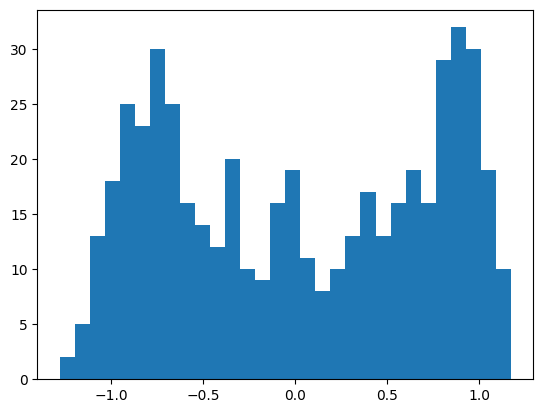

In [6]:
# histogram of y
plt.hist(df['y'], bins=30)

### 1. Scale features to [-1, 1]

In [7]:
print(dir(data_utils))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'generate_synthetic_data', 'np', 'pd', 'scale_min_max', 'scale_z_score']


In [8]:
# scale features to [-1, 1]
feature_cols = df.columns[:-1]  # all columns except the last 1 (one-hot encoded target)

df[feature_cols] = data_utils.scale_min_max(df[feature_cols], min_val=-1, max_val=1)
df.head()

,x,y
0,-0.695283,0.933592
1,0.480000,-1.119466
2,-0.476325,1.092499
3,0.066143,-0.327187
4,-0.975295,0.058040


### 2. Prepare X and Y matrices and tensors


In [9]:
df['y']

0      0.933592
1     -1.119466
2      1.092499
3     -0.327187
4      0.058040
         ...   
495    0.973097
496   -0.794886
497    0.651283
498    0.620207
499   -0.114651
Name: y, Length: 500, dtype: float64

In [10]:
# Prepare data
X = df[feature_cols].values
y = df['y'].values.reshape(-1, 1)
y_raw = y.copy()



# Convert to torch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [11]:
# set matplotlib to Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14


In [12]:
results_dir = "../results/synfunc"
best_params_filename = os.path.join(results_dir, "best_hyperparameters.pkl")

# Check if the file exists
if os.path.exists(best_params_filename):
    with open(best_params_filename, 'rb') as f:
        loaded_best_params = pickle.load(f)
    
    print("Successfully loaded best parameters:")
    print(f"Best parameters: {loaded_best_params}")
    
    # Verify they match the current best_params
    if 'best_params' in locals():
        print(f"Parameters match current session: {best_params == loaded_best_params}")
    
    # Use loaded parameters (in case we're running this cell independently)
    best_params = loaded_best_params
    
else:
    print(f"Best parameters file not found at: {best_params_filename}")
    print("Make sure to run the hyperparameter search first!")

Successfully loaded best parameters:
Best parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.010937669314444065, 'test_mse': 0.011201427318155766, 'train_r2': 0.978721022605896, 'test_r2': 0.9779318571090698}


#### Add input and output sizes to params

In [13]:
# Set correct input and output sizes for regression
best_params['input_size'] = 1  # Single input feature (x)
best_params['output_size'] = 1  # Single output value (y)

In [14]:
# Option 1: Use AdaptiveNet (recommended - minimal code changes)
# This model can handle both classification and regression

# First, let's patch the active learning code to use AdaptiveNet for regression
# This is a simple monkey patch that requires minimal changes

# Save the original NeuralNet import
from src.models import AdaptiveNet
from sklearn.model_selection import KFold  # For regression CV (no stratification)

# Create a custom ModelEvaluator for regression
class RegressionModelEvaluator(ModelEvaluator):
    def evaluate_passive_learning(self, X, y, best_params, n_trials=50,
                                 use_cv=True, cv_folds=5, epochs=1000, 
                                 random_state=42, model_class=None):
        """
        Override to handle regression data (no one-hot encoding).
        
        Args:
            X: Input features tensor
            y: Target values tensor (continuous values, not one-hot)
            best_params: Dictionary with best hyperparameters
            n_trials: Number of trials to run
            use_cv: Whether to use cross-validation
            cv_folds: Number of CV folds
            epochs: Maximum epochs per trial
            random_state: Base random state
            
        Returns:
            Dictionary with comprehensive evaluation results
        """
        print(f"Starting {n_trials} trial evaluation...")
        print(f"Parameters: {best_params}")
        print(f"Cross-validation: {'Yes' if use_cv else 'No'} ({cv_folds} folds)")
        
        self.metrics_tracker.reset()
        
        # For regression, y is already continuous values, no need to convert
        # Use y directly as indices (dummy variable for compatibility)
        y_indices = y
        
        for trial in range(n_trials):
            print(f"Trial {trial + 1}/{n_trials}", end="... ")
            
            start_time = time.time()
            
            if use_cv:
                # Cross-validation approach
                trial_results = self._run_cv_trial(X, y, y_indices, best_params, 
                                                 cv_folds, epochs, random_state + trial, model_class)
            else:
                # Simple train-test split approach
                trial_results = self._run_simple_trial(X, y, y_indices, best_params, 
                                                     epochs, random_state + trial, model_class)
            
            computation_time = time.time() - start_time
            
            # Add results to tracker
            self.metrics_tracker.add_trial_results(
                train_acc=trial_results['train_acc'],
                test_acc=trial_results['test_acc'],
                val_acc=trial_results.get('val_acc'),
                losses=trial_results['losses'],
                val_losses=trial_results.get('val_losses'),
                epochs_converged=trial_results['epochs_converged'],
                num_presentations=trial_results['num_presentations'],
                computation_time=computation_time,
                train_metrics=trial_results.get('train_metrics'),
                test_metrics=trial_results.get('test_metrics'),
                val_metrics=trial_results.get('val_metrics'),
                train_acc_curve=trial_results.get('train_acc_curve'),
                test_acc_curve=trial_results.get('test_acc_curve')
            )
            
            print(f"Test MSE: {-trial_results['test_acc']:.4f}, Time: {computation_time:.2f}s")
        
        # Compute and return comprehensive statistics
        results = self.metrics_tracker.compute_statistics()
        results['learning_type'] = 'passive'
        results['best_params'] = best_params
        
        return results
    
    def _train_model(self, X_train, y_train_idx, X_test, y_test_idx, params, epochs):
        """Override to use AdaptiveNet for regression"""
        
        # Use AdaptiveNet configured for regression
        model = AdaptiveNet(
            input_size=params.get('input_size', 1),
            hidden_size=params['hidden_size'],
            output_size=params.get('output_size', 1),
            use_mse=False,  # We'll use MSE loss externally
            task_type='regression'
        )
        
        # Use MSE loss for regression
        criterion = nn.MSELoss()
        optimizer = optim.SGD(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay'],
            momentum=params.get('momentum', 0.0)
        )
        
        # For regression, targets are already in the right format (continuous values)
        # Convert indices to float if they aren't already
        y_train_target = y_train_idx.float().unsqueeze(1) if y_train_idx.dim() == 1 else y_train_idx.float()
        y_test_target = y_test_idx.float().unsqueeze(1) if y_test_idx.dim() == 1 else y_test_idx.float()
        
        # Training loop
        losses = []
        val_losses = []
        train_acc_curve = []
        test_acc_curve = []
        
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train_target)
            loss.backward()
            
            # IMPORTANT: Add gradient clipping to match original training!
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            losses.append(loss.item())
            
            # Validation step
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test)
                val_loss = criterion(val_outputs, y_test_target)
                val_losses.append(val_loss.item())
                
                # For regression, use negative MSE as "accuracy" (higher is better)
                train_outputs = model(X_train)
                train_mse = nn.MSELoss()(train_outputs, y_train_target)
                test_mse = nn.MSELoss()(val_outputs, y_test_target)
                
                train_epoch_acc = -train_mse.item()
                test_epoch_acc = -test_mse.item()
                
                train_acc_curve.append(train_epoch_acc)
                test_acc_curve.append(test_epoch_acc)
        
        # Find convergence epoch
        epochs_converged = find_convergence_epoch(losses)
        
        # Final evaluation
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)
            test_outputs = model(X_test)
            
            train_mse = nn.MSELoss()(train_outputs, y_train_target)
            test_mse = nn.MSELoss()(test_outputs, y_test_target)
            
            train_acc = -train_mse.item()
            test_acc = -test_mse.item()
            
            # Create dummy metrics for regression (since classification metrics don't apply)
            train_metrics = {'accuracy': train_acc, 'f1_score': train_acc, 'precision': train_acc, 'recall': train_acc}
            test_metrics = {'accuracy': test_acc, 'f1_score': test_acc, 'precision': test_acc, 'recall': test_acc}
        
        return model, losses, train_acc, test_acc, epochs_converged, train_metrics, test_metrics, val_losses, train_acc_curve, test_acc_curve

    def _run_cv_trial(self, X, y, y_indices, params, cv_folds, epochs, random_state, model_class=None):
        """Override CV trial for regression - no stratification needed"""
        
        # First, create a holdout test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )
        
        # Use regular KFold instead of StratifiedKFold for regression
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        
        # Cross-validation metrics tracking
        cv_train_accs = []
        cv_val_accs = []
        cv_train_metrics = []
        cv_val_metrics = []
        all_losses = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_temp)):
            X_train = X_temp[train_idx]
            X_val = X_temp[val_idx]
            y_train = y_temp[train_idx]
            y_val = y_temp[val_idx]
            
            # Train model (y_train and y_val are already continuous values)
            model, losses, train_acc, val_acc, _, train_metrics, val_metrics, val_losses, _, _ = self._train_model(
                X_train, y_train, X_val, y_val, params, epochs
            )
            
            cv_train_accs.append(train_acc)
            cv_val_accs.append(val_acc)
            cv_train_metrics.append(train_metrics)
            cv_val_metrics.append(val_metrics)
            all_losses.extend(losses)
        
        # Average CV results
        avg_train_acc = np.mean(cv_train_accs)
        avg_val_acc = np.mean(cv_val_accs)
        
        # Average CV metrics
        avg_train_metrics = self._average_metrics(cv_train_metrics)
        avg_val_metrics = self._average_metrics(cv_val_metrics)
        
        # Final test on holdout set using best parameters
        # Train on all temp data for final test
        final_model, final_losses, _, _, epochs_converged, _, test_metrics, final_val_losses, train_acc_curve, test_acc_curve = self._train_model(
            X_temp, y_temp, X_test, y_test, params, epochs
        )
        
        # Evaluate on test set
        final_model.eval()
        with torch.no_grad():
            test_outputs = final_model(X_test)
            test_target = y_test.float().unsqueeze(1) if y_test.dim() == 1 else y_test.float()
            test_mse = nn.MSELoss()(test_outputs, test_target)
            test_acc = -test_mse.item()  # Use negative MSE as "accuracy"
        
        # Calculate pattern presentations
        num_presentations = len(X_temp) * epochs_converged
        
        return {
            'train_acc': avg_train_acc,
            'val_acc': avg_val_acc,
            'test_acc': test_acc,
            'losses': all_losses,
            'val_losses': final_val_losses,
            'train_metrics': avg_train_metrics,
            'val_metrics': avg_val_metrics,
            'test_metrics': test_metrics,
            'epochs_converged': epochs_converged,
            'num_presentations': num_presentations,
            'train_acc_curve': train_acc_curve,
            'test_acc_curve': test_acc_curve
        }
    
    def _run_simple_trial(self, X, y, y_indices, params, epochs, random_state, model_class=None):
        """Override simple trial for regression"""
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )
        
        # Train model
        model, losses, train_acc, test_acc, epochs_converged, train_metrics, test_metrics, val_losses, train_acc_curve, test_acc_curve = self._train_model(
            X_train, y_train, X_test, y_test, params, epochs
        )
        
        # Calculate pattern presentations
        num_presentations = len(X_train) * epochs_converged
        
        return {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'losses': losses,
            'val_losses': val_losses,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'epochs_converged': epochs_converged,
            'num_presentations': num_presentations,
            'train_acc_curve': train_acc_curve,
            'test_acc_curve': test_acc_curve
        }

print("Created RegressionModelEvaluator with Cross-Validation support!")
print("✓ Supports both CV and simple train-test splits")
print("✓ Uses KFold (no stratification) for regression")
print("✓ Uses MSE-based metrics instead of classification metrics")
print("✓ Overrides evaluate_passive_learning to handle regression data")
print("✓ Includes gradient clipping (max_norm=1.0) to match original training")

Created RegressionModelEvaluator with Cross-Validation support!
✓ Supports both CV and simple train-test splits
✓ Uses KFold (no stratification) for regression
✓ Uses MSE-based metrics instead of classification metrics
✓ Overrides evaluate_passive_learning to handle regression data
✓ Includes gradient clipping (max_norm=1.0) to match original training


#### Run 50 trials with best control parameters

In [15]:
# Initialize evaluator
evaluator = RegressionModelEvaluator()

# Fix y_tensor format - squeeze to remove extra dimensions
y_for_eval = y_tensor.squeeze()

# Run 50 trials with cross-validation
print("Running 50 trials with best parameters and 5-fold cross-validation...")
print(f"Data shapes: X={X_tensor.shape}, y={y_for_eval.shape}")
print(f"Best params from original training: {best_params}")
print()

passive_results = evaluator.evaluate_passive_learning(
    X=X_tensor,
    y=y_for_eval,  # Use properly formatted y
    best_params=best_params,
    n_trials=50,
    use_cv=False, 
    cv_folds=5,
    epochs=1000, 
    random_state=12,
)

# Print comprehensive report
print("\n")
evaluator.print_report()

Running 50 trials with best parameters and 5-fold cross-validation...
Data shapes: X=torch.Size([500, 1]), y=torch.Size([500])
Best params from original training: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.010937669314444065, 'test_mse': 0.011201427318155766, 'train_r2': 0.978721022605896, 'test_r2': 0.9779318571090698, 'input_size': 1, 'output_size': 1}

Starting 50 trial evaluation...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.010937669314444065, 'test_mse': 0.011201427318155766, 'train_r2': 0.978721022605896, 'test_r2': 0.9779318571090698, 'input_size': 1, 'output_size': 1}
Cross-validation: No (5 folds)
Trial 1/50... Test MSE: 0.1725, Time: 1.22s
Trial 2/50... Test MSE: 0.1725, Time: 1.22s
Trial 2/50... Test MSE: 0.2471, Time: 0.48s
Trial 3/50... Test MSE: 0.2471, Time: 0.48s
Trial 3/50... Test MSE: 0.0101, Time: 0.45s
Trial 4/50... Test MSE: 0.0101, Time: 0.45s
Tri

KeyboardInterrupt: 